In [13]:
import psycopg2
import pandas as pd
pgconn = psycopg2.connect(database='sustainablecorn', host='iemdb', user='nobody')
cursor = pgconn.cursor()
pd.set_printoptions(max_rows=400, max_columns=10)
cursor.execute("""
 SELECT a.site, a.plotid, varname, year, value, p.rotation, p.tillage from agronomic_data a JOIN plotids p
 ON (p.uniqueid = a.site and p.plotid = a.plotid) where
 varname in ('AGR7', 'AGR17', 'AGR19', 'AGR39') and 
 value ~* '[0-9\.]' and value != '.' and value !~* '<' 
""")
data = {}
for row in cursor:
    key = '%s|%s|%s' % (row[0], row[1], row[3])
    if not data.has_key(key):
        data[key] = {'rotation': row[5], 'tillage': row[6]}
    data[key][ row[2] ] = float(row[4])

rows = []
for key in data.keys():
    tokens = key.split("|")
    rows.append( dict(siteid=tokens[0], plotid=row[1], year=tokens[2], 
                      agr7=data[key].get('AGR7'), 
                      agr17=data[key].get('AGR17'), 
                      agr19=data[key].get('AGR19'), 
                      agr39=data[key].get('AGR39'),
                      rotation=data[key]['rotation'],
                      tillage=data[key]['tillage']
                      ) )
    
df = pd.DataFrame(rows)
df.fillna(np.nan)
print 'Loaded %s rows from the database!' % (len(df),)

Loaded 1671 rows from the database!


Okay, for each site, we want to:

* average the biomass AGR7
* average the yield AGR17 and AGR19 for ROT4 and ROT5
* average the yield AGR17 and AGR19 for ROT36 and ROT37

In [23]:
def a(ar):
    if len(ar[ar.notnull()]) == 0:
        return None
    return np.ma.average(ar[ar.notnull()])

rows = []
for year in ["2011", "2012", "2013"]:
    for sid in df.siteid.unique():
        agr7 = df[(df.siteid==sid)&(df.year==year)].agr7
        if len(agr7[agr7.notnull()]) == 0:
            continue
        agr7 = np.average(agr7[agr7.notnull()])
        
        cyield_nocc = a( df[(df.siteid==sid)&(df.year==year)&
                       ((df.rotation=='ROT4')|(df.rotation=='ROT5'))].agr17)
        syield_nocc = a( df[(df.siteid==sid)&(df.year==year)&
                       ((df.rotation=='ROT4')|(df.rotation=='ROT5'))].agr19)
        cyield_cc = a( df[(df.siteid==sid)&(df.year==year)&
                       ((df.rotation=='ROT36')|(df.rotation=='ROT37'))].agr17)
        syield_cc = a( df[(df.siteid==sid)&(df.year==year)&
                       ((df.rotation=='ROT36')|(df.rotation=='ROT37'))].agr19)

        rows.append( dict(siteid=sid, year=year, ryebio=agr7, 
                          cyield_nocc=cyield_nocc, syield_nocc=syield_nocc, 
                          cyield_cc=cyield_cc,     syield_cc=syield_cc) )
        
df2 = pd.DataFrame(rows)

In [24]:
df2.sort('ryebio')

,cyield_cc,cyield_nocc,ryebio,siteid,syield_cc,syield_nocc,year
19,3720.995308,4067.914012,140.383333,KELLOGG,NaN,NaN,2013
9,NaN,NaN,226.666667,KELLOGG,681.692583,726.318656,2012
23,7036.350751,7438.375154,227.166667,MASON,NaN,NaN,2013
1,2240.000000,2804.166667,240.000000,KELLOGG,NaN,NaN,2011
4,7960.500000,8558.437500,243.200000,GILMORE,1859.600000,2034.887500,2012
16,9008.777333,8096.911167,273.956522,FREEMAN,3417.550780,3014.481114,2013
14,9123.800000,9213.725000,329.716250,GILMORE,2470.550000,2530.725000,2013
6,3560.590500,5144.944000,337.625000,FREEMAN,2158.938500,2598.866833,2012
13,NaN,NaN,423.333333,MASON,2173.472301,2274.262024,2012
0,9660.200000,10656.037500,435.893750,GILMORE,2482.050000,2668.150000,2011


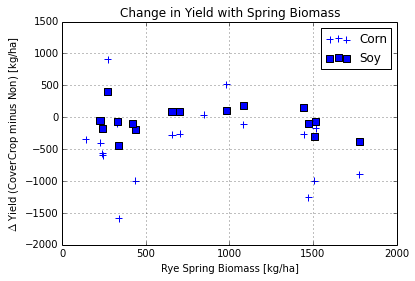

In [26]:
df3 = df2[(df2.siteid!='WOOSTER.COV')]
(fig, ax) = plt.subplots(1,1)

ax.scatter(df3.ryebio, df3.cyield_cc - df3.cyield_nocc, marker='+', s=50, label='Corn')
ax.scatter(df3.ryebio, df3.syield_cc - df3.syield_nocc, marker='s', s=50, label='Soy')
ax.legend()
ax.set_ylabel("$\Delta$ Yield (CoverCrop minus Non) [kg/ha]")
ax.set_xlabel("Rye Spring Biomass [kg/ha]")
ax.set_title("Change in Yield with Spring Biomass")
ax.grid(True)